In [17]:


# Start of Selection
# ---
# jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: light
#       format_version: '1.5'
#       jupytext_version: 1.14.5
#   kernelspec:
#     display_name: Python 3
#     language: python
#     name: python3
# ---

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)
Début de l'entraînement...
Epoch    0, PINN Loss: 0.044856, L2 Loss: 0.040887


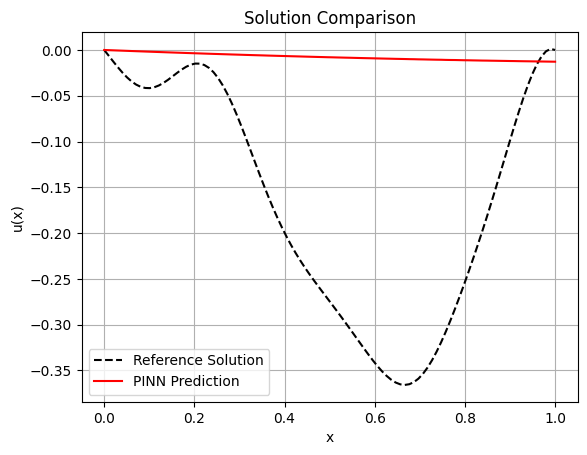

Epoch  200, PINN Loss: 0.043540, L2 Loss: 0.040350


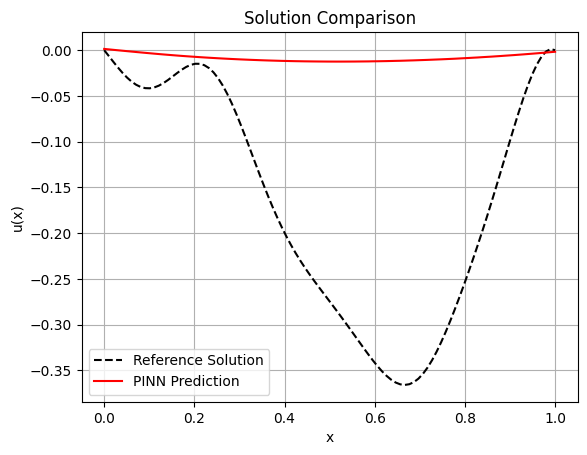

Epoch  400, PINN Loss: 0.031819, L2 Loss: 0.010815


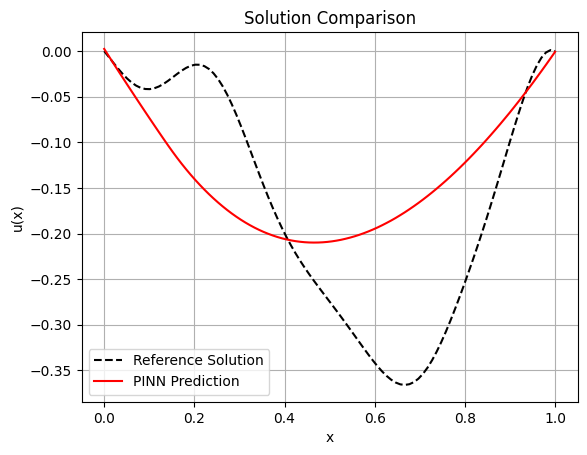

Epoch  600, PINN Loss: 0.010583, L2 Loss: 0.004780


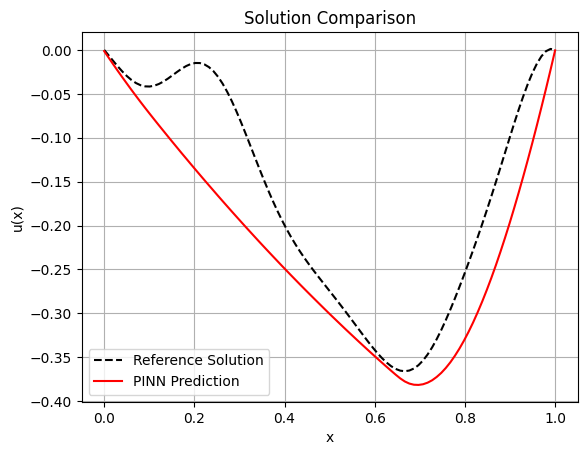

Epoch  800, PINN Loss: 0.009271, L2 Loss: 0.004260


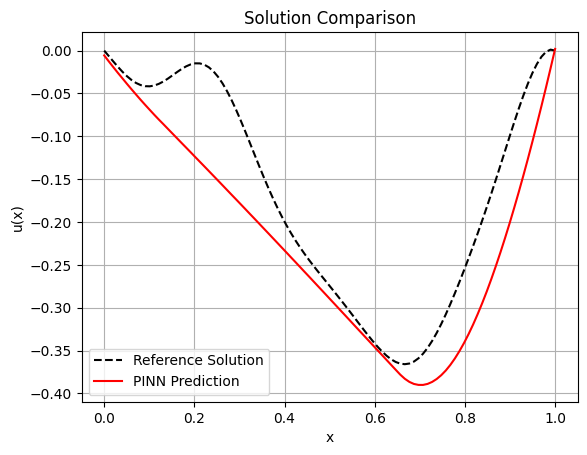

Epoch 1000, PINN Loss: 0.005751, L2 Loss: 0.002853


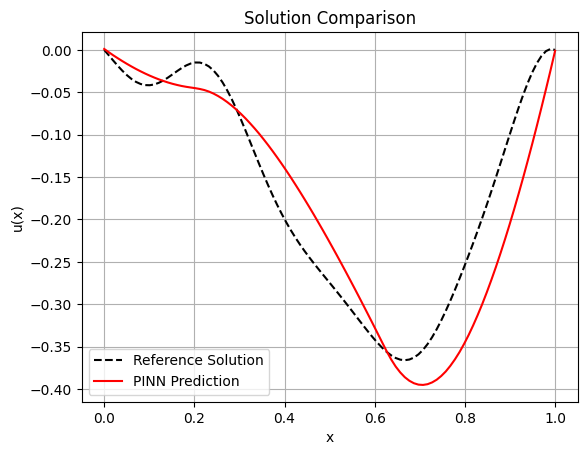

Epoch 1200, PINN Loss: 0.003956, L2 Loss: 0.002771


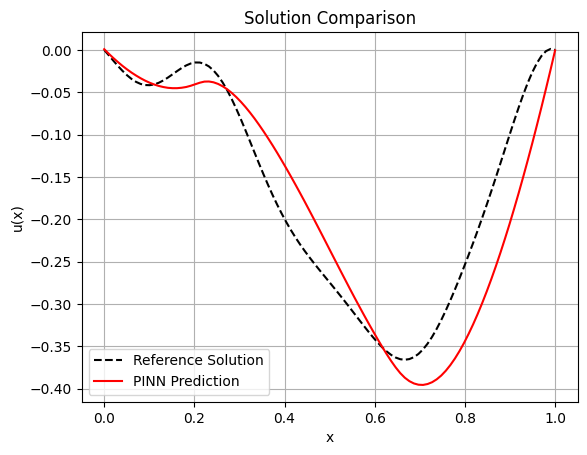

Epoch 1400, PINN Loss: 0.001702, L2 Loss: 0.002579


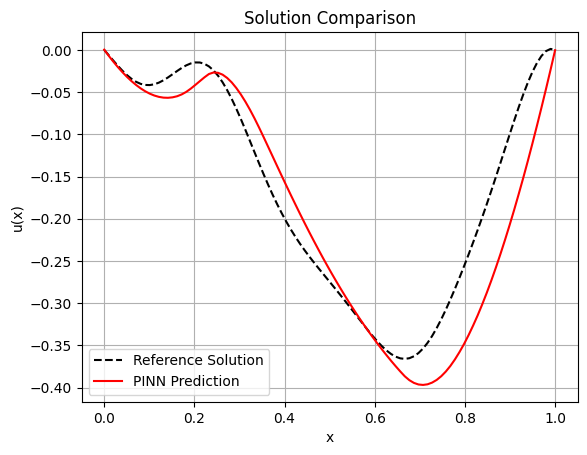

Epoch 1600, PINN Loss: 0.001311, L2 Loss: 0.002553


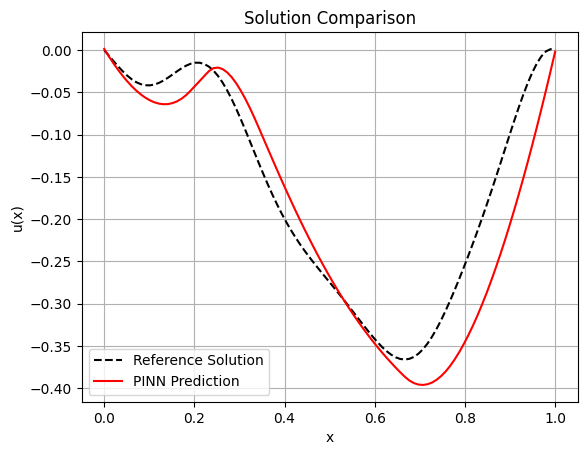

Epoch 1800, PINN Loss: 0.001224, L2 Loss: 0.002469


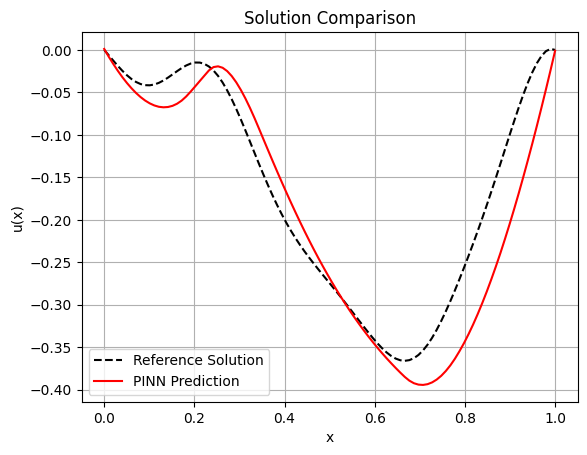

Epoch 2000, PINN Loss: 0.001251, L2 Loss: 0.002114


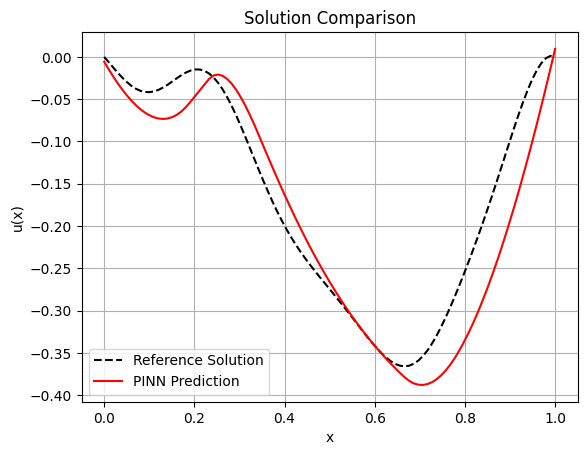

Entraînement terminé.


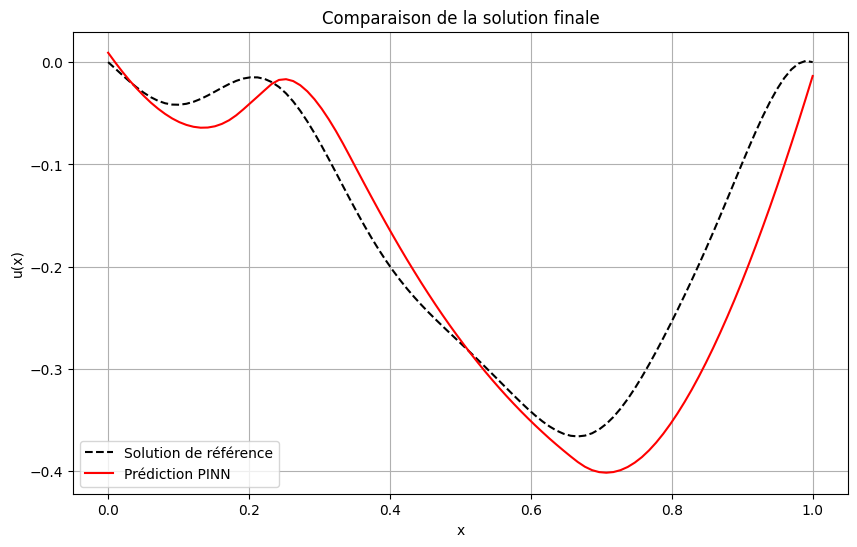

In [18]:
# mon approche ici est de construire un pinn qui résout l'edp, pour un f fixé à chaque fois.
# j'essaie de trouver un pinn qui résout l'edp associée avec une fonction de perte edp personnalisée.

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sciml.data.preprocessing.process_given_dataset import get_mu_xs_sol

# --- 1. Définition du modèle ---
def create_pinn_model():
    """Un modèle Keras simple et standard."""
    inputs = tf.keras.Input(shape=(1,))
    x_ = tf.keras.layers.Dense(512, activation='elu')(inputs)
    x_ = tf.keras.layers.Dense(512, activation='elu')(x_)
    outputs = tf.keras.layers.Dense(1)(x_)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# --- 2. Chargement et préparation des données ---
# nous chargeons les données et prenons seulement la première fonction
all_mus, _, all_sols = get_mu_xs_sol(folder_path='/home/janis/SCIML/summerschool/data/benchmarks/given/', type=0.2, training=True)
mu_func = all_mus[1]
sol_func = all_sols[1]

# nous définissons le domaine spatial x et nous nous assurons que tout est en float32
x = tf.linspace(0., 1., 100)
x = tf.cast(tf.reshape(x, (-1, 1)), tf.float32)
mu_tensor = tf.cast(tf.reshape(mu_func, (-1, 1)), tf.float32)
sol_tensor = tf.cast(tf.reshape(sol_func, (-1, 1)), tf.float32)

# --- 3. Configuration de l'entraînement ---
model = create_pinn_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
coeff = tf.constant([[-0.01, 0.2, 0]], dtype=tf.float32)

# --- 4. Boucle d'entraînement simple ---
print("Début de l'entraînement...")
for epoch in range(2001): # 2000 époques
    with tf.GradientTape() as tape: # ce tape calcule les gradients pour mettre à jour les poids
        with tf.GradientTape(persistent=True) as pde_tape: # ce tape calcule les dérivées par rapport à x
            pde_tape.watch(x)
            u_pred = model(x, training=True)
        
        # nous calculons les dérivées première et seconde
        du_dx = pde_tape.gradient(u_pred, x)
        d2u_dx2 = pde_tape.gradient(du_dx, x)
        del pde_tape # nous libérons la mémoire du tape persistant
        
        # nous ajoutons une sécurité si une dérivée est nulle
        if du_dx is None: du_dx = tf.zeros_like(x)
        if d2u_dx2 is None: d2u_dx2 = tf.zeros_like(x)

        # Perte de l'EDP (physique)
        pde_residual = coeff[0, 0] * d2u_dx2 + coeff[0, 1] * du_dx + coeff[0, 2] * u_pred - mu_tensor
        loss_pde = tf.reduce_mean(tf.square(pde_residual))

        # Perte aux bords u(0)=0 et u(1)=0
        # LA CORRECTION CLÉ : u_pred[0, 0] extrait un scalaire, ce qui garantit que la perte est un scalaire
        u_at_0 = u_pred[0, 0]
        u_at_1 = u_pred[-1, 0]
        loss_bc = tf.square(u_at_0) + tf.square(u_at_1)
        
        # Perte totale
        total_loss = loss_pde + 0.5*loss_bc

    # nous mettons à jour les poids du réseau
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % 200 == 0:
        # we compute l2 loss just for display, it's not used for training
        l2_loss = tf.reduce_mean(tf.square(u_pred - sol_tensor))
        print(f"Epoch {epoch:4d}, PINN Loss: {total_loss:.6f}, L2 Loss: {l2_loss:.6f}")
        plt.plot(x.numpy(), sol_tensor.numpy(), 'k--', label='Reference Solution')
        plt.plot(x.numpy(), u_pred.numpy(), 'r-', label='PINN Prediction')
        plt.title("Solution Comparison")
        plt.xlabel("x")
        plt.ylabel("u(x)")
        plt.legend()
        plt.grid(True)
        plt.show()

print("Entraînement terminé.")

# --- 5. Visualisation du résultat final ---
final_pred = model(x)

plt.figure(figsize=(10, 6))
plt.plot(x.numpy(), sol_tensor.numpy(), 'k--', label='Solution de référence')
plt.plot(x.numpy(), final_pred.numpy(), 'r-', label='Prédiction PINN')
plt.title("Comparaison de la solution finale")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.show()